In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import IPython.display as ipd

In [2]:
df = pd.read_pickle('../data/taylor_df.pkl')

In [3]:
df.head()

,name,song_wave,scene_start_times_sec,onset_times_sec
0,Taylor Swift - White Horse-D1Xr-JFLxik,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.000 1 0.667 2 3.587 3...,"[0.6965986394557823, 1.3467573696145125, 1.648..."
1,Taylor Swift - The Story Of Us-nN6VR92V70M,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.000 1 0.500 2 1.417 3...,"[0.6501587301587302, 0.905578231292517, 1.0913..."
2,Taylor Swift - Delicate-tCXGJQYZ9JA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.000 1 3.045 2 6.715 3 ...,"[3.8312925170068026, 4.040272108843538, 4.2028..."
3,Taylor Swift - Style--CmadmM5cOk,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.000 1 7.424 2 9.259 3...,"[0.11609977324263039, 10.077460317460318, 10.4..."
4,Taylor Swift - ME! (feat. Brendon Urie of Pani...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.000 1 0.500 2 5.255 3 ...,"[17.29886621315193, 19.11002267573696, 19.6208..."


In [4]:
df.scene_start_times_sec[0]

0        0.000
1        0.667
2        3.587
3        8.467
4       13.472
        ...   
122    229.688
123    231.606
124    233.233
125    238.405
126    241.700
Name: Start Time (seconds), Length: 127, dtype: float64

## RQA for sequence alignment

In [123]:
def my_rqa2(sim, gap_onset=5, gap_extend=10, plot=False):
    """ calc and plor RQA """ 
    score, path = librosa.sequence.rqa(sim, gap_onset, gap_extend)
    best_score = score.max()
    
    if plot:
        plt.figure(figsize=(10, 4))
        plt.subplot(1,2,1)
        librosa.display.specshow(sim, x_axis='frames', y_axis='frames')
        plt.title('Similarity matrix')
        plt.colorbar()
        plt.subplot(1,2,2)
        librosa.display.specshow(score, x_axis='frames', y_axis='frames')
        plt.title(f'Alignment score matrix ({best_score})')
        plt.plot(path[:, 1], path[:, 0], label='Optimal path', color='c')
        plt.colorbar()
        plt.legend()
        plt.show()
    return best_score, score, path

In [8]:
query_song = df.song_wave[0]

Extract features

In [9]:
spectral_novelty = librosa.onset.onset_strength(query_song)

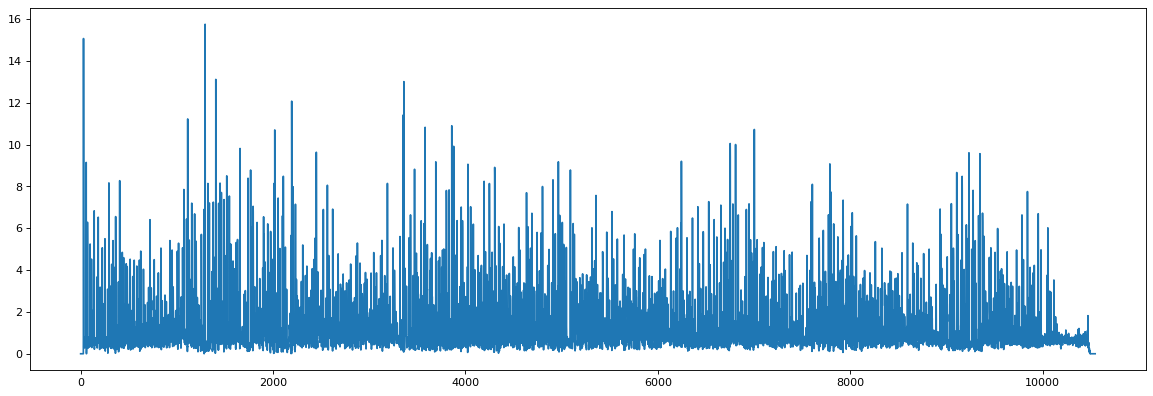

In [14]:
fig=plt.figure(figsize=(18, 6), dpi= 80)
plt.plot(spectral_novelty)

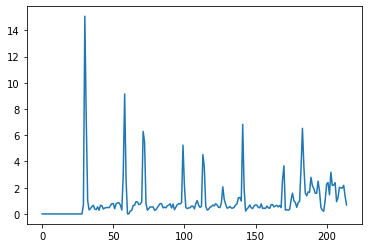

In [56]:
idx = slice(*librosa.time_to_frames([0, 5]))
plt.plot(spectral_novelty[idx])

In [27]:
def subseq(seq, from_sec, to_sec):
    idx = slice(*librosa.time_to_frames([from_sec, to_sec]))
    return seq[idx]

### sanity check: align song to itself

In [124]:
from scipy.spatial import distance_matrix

song_i=0

seq_starts = df.scene_start_times_sec[song_i].copy()
song_len = librosa.samples_to_time(len(df.song_wave[song_i]))
# append last seq end
seq_starts[len(seq_starts)] = song_len

min_i = 0
n=len(seq_starts)-1
best_scores = np.zeros([n,n])
for i in range(min_i, n):
    start1 = seq_starts[i]
    end1 = seq_starts[i+1]
    features1 = subseq(spectral_novelty, start1, end1)
    if i % 10 == 0:
        print(i)
    for j in range(i, n):
        start2=seq_starts[j]
        end2=seq_starts[j+1]
        features2 = subseq(spectral_novelty, start2, end2)
#         sim = librosa.segment.cross_similarity(features1, features2, 
#                                                 mode='affinity',
        dists = distance_matrix(features1.reshape([len(features1),1]),
                   features2.reshape([len(features2),1]))
        similarities = 0.5-dists
        best_score, score, path = my_rqa2(similarities)
        best_scores[i,j] = best_score
        

0
10
20
30
40
50
60
70
80
90
100
110
120


plot the scores of the scenes. see that scenes are similar to themselves

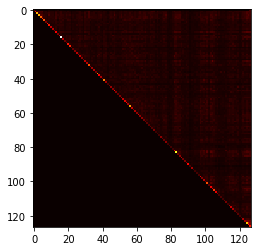

In [125]:
plt.imshow(best_scores, cmap='hot')

find best match off the diagonal

In [153]:
# remove the main diagonal and a buffer above it so we don't get scenes that are close together
upper = (np.triu(best_scores,4))
i,j = np.unravel_index(upper.argmax(), upper.shape)
start1 = seq_starts[i]
end1 = seq_starts[i+1]
start2 = seq_starts[j]
end2 = seq_starts[j+1]

In [155]:
# make sure it's not the same scene
print([start1, end1, start2, end2])

[74.908, 76.994, 204.329, 206.748]


In [156]:
sr=22050
sec_start = seq_starts[i]
loc_start = sec_start * sr
loc_end = (seq_starts[i+1]) * sr
ipd.Audio(query_song[int(loc_start):int(loc_end)], rate=sr)

In [157]:
sr=22050
sec_start = seq_starts[j]
loc_start = sec_start * sr
loc_end = (seq_starts[j+1]) * sr
ipd.Audio(query_song[int(loc_start):int(loc_end)], rate=sr)

## Now match first song to all others

In [158]:
def calc_similarities(features1, features2, max_dist=0.5):
    dists = distance_matrix(features1.reshape([len(features1),1]),
                   features2.reshape([len(features2),1]))
    return max_dist-dists

In [ ]:
def get_scenes(df, song_i):
    song_i=0
    seq_starts_i = df.scene_start_times_sec[song_i].copy()
    song_len = librosa.samples_to_time(len(df.song_wave[song_i]))
    # append last seq end
    seq_starts_i[len(seq_starts)] = song_len
    return seq_starts_i
    
# min_i = 0
# n=len(seq_starts)-1
# best_scores = np.zeros([n,n])
# for i in range(min_i, n):
#     start1 = seq_starts[i]
#     end1 = seq_starts[i+1]
#     features1 = subseq(spectral_novelty, start1, end1)
#     if i % 10 == 0:
#         print(i)
#     for j in range(i, n):
#         start2=seq_starts[j]
#         end2=seq_starts[j+1]
#         features2 = subseq(spectral_novelty, start2, end2)
# #         sim = librosa.segment.cross_similarity(features1, features2, 
# #                                                 mode='affinity',
#         dists = distance_matrix(features1.reshape([len(features1),1]),
#                    features2.reshape([len(features2),1]))
#         similarities = 0.5-dists
#         best_score, score, path = my_rqa2(similarities)
#         best_scores[i,j] = best_score